# Build classifiers based on the Forbes dataset, then attempt to explain the model.

## Import and configure

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import accuracy_score

from xgboost import XGBRegressor

from config import DATASET_PATH

/Users/ducnguyen/workspaces/lab/forbes-classifier/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Configurations for the classifier
categorical_columns = ["Industry", "Country", "Market_Value_class", "Sales_class", "Profits_class", "Assets_class", "Rank_class"]
noise_features = ["DBpedia_URI", "Company"]
target_feature = "Profits_class"
test_size = 0.15

## Load and split the dataset

In [3]:
# Load the dataset
dataset = pd.read_csv(DATASET_PATH)

In [4]:
# Preprocess the dataset
if target_feature == "Market_Value_class":
    noise_features.append("Market_Value")
elif target_feature == "Sales_class":
    noise_features.append("Sales")
elif target_feature == "Profits_class":
    noise_features.append("Profits")
elif target_feature == "Assets_class":
    noise_features.append("Assets")
elif target_feature == "Rank_class":
    noise_features.append("Rank")

dataset.drop(columns=dataset.columns[0], axis=1, inplace=True)
dataset.drop(columns=noise_features, axis=1, inplace=True)

# One hot encoding categorial columns
dataset = pd.get_dummies(dataset, columns=[elm for elm in categorical_columns if elm != target_feature], drop_first=True)
dataset.head()

,Market_Value,Sales,Assets,Rank,Profits_class,Industry_Aerospace_&_Defense,Industry_Air_Courier,Industry_Airline,Industry_Aluminum,Industry_Apparel/Accessories,...,Country_United_Arab_Emirates,Country_United_Kingdom,Country_United_States,Market_Value_class_low,Market_Value_class_mid,Sales_class_low,Sales_class_mid,Assets_class_mid,Rank_class_low,Rank_class_mid
0,9.5,7.6,14.5,1242,low,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
1,11.9,12.5,11.5,875,mid,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,1
2,16.0,17.2,122.1,373,mid,0,0,0,0,0,...,0,0,0,0,1,0,1,1,1,0
3,81.2,37.5,666.9,66,high,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3.1,2.8,43.0,1751,low,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [5]:
# Split dataset for training
def encode_label(dataframe):
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(dataframe)
    return label_encoder.transform(dataframe), label_encoder

def split_dataset(dataset, target_column = target_feature, test_size = test_size):
    y, le = encode_label(dataset[target_column])
    x = dataset.drop(target_column, axis=1)
    x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=test_size)
    return x_train, y_train, x_test, y_test, le

x_train, x_test, y_train, y_test, le = split_dataset(dataset)

In [6]:
print("Categorial value of the classifier target:")
le.classes_

Categorial value of the classifier target:


array(['high', 'low', 'mid'], dtype=object)

In [7]:
x_train

,Market_Value,Sales,Assets,Rank,Industry_Aerospace_&_Defense,Industry_Air_Courier,Industry_Airline,Industry_Aluminum,Industry_Apparel/Accessories,Industry_Apparel/Footwear_Retail,...,Country_United_Arab_Emirates,Country_United_Kingdom,Country_United_States,Market_Value_class_low,Market_Value_class_mid,Sales_class_low,Sales_class_mid,Assets_class_mid,Rank_class_low,Rank_class_mid
470,4.7,1.2,1.9,1959,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
41,6.6,12.4,50.0,723,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,0
893,14.9,7.2,9.2,892,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1
1083,1.6,15.3,9.2,1683,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0
1021,7.5,0.6,13.0,1206,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,400.4,420.7,333.8,5,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
314,25.4,51.7,80.9,162,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
1016,2.9,15.4,9.2,1680,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0
1175,13.1,8.1,8.6,926,0,0,0,0,0,0,...,0,0,1,0,1,1,0,1,0,1


In [8]:
# Encoded labels of the classifier target column
y_train

array([2, 2, 2, ..., 1, 2, 2])

## Train the model

In [9]:
model = XGBRegressor().fit(x_train, y_train)

## Evaluate the model

In [10]:
# Make predictions with the test dataset and calculate accuracy
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.71%


## Explain the trained model

In [11]:
import shap

In [12]:
# Iterate the test data with SHAP to explain how the model reached the current state
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


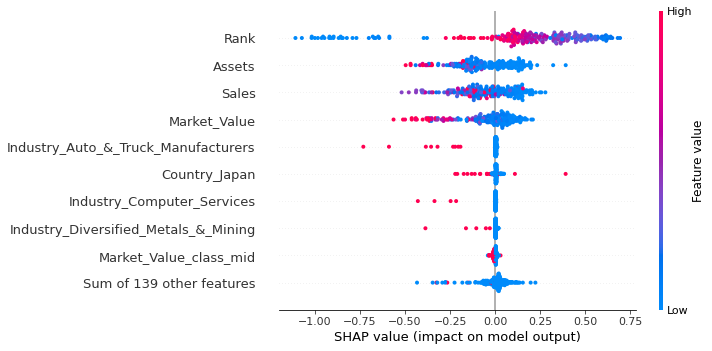

In [13]:
shap.plots.beeswarm(shap_values)

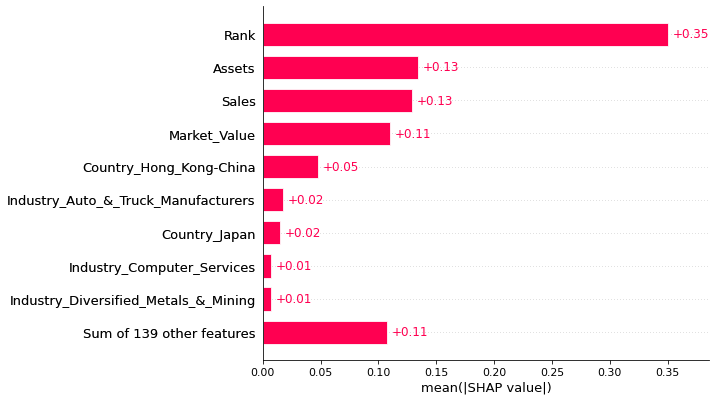

In [14]:
shap.plots.bar(shap_values)

## Playground with own defined data

### 1. Prepare the data

In [15]:
mock_data = {
    "": [0],
    'Company': ["Duc_Inc"],
    'Industry': ["Real_Estate"],
    'Country': ["United_States"],
    'Market_Value': [3],
    "Sales": [3],
    "Profits": [0.7],
    "Assets": [1.5],
    "Rank": [1990],
    "DBpedia_URI": ["https://wiki/duc"],
    "Market_Value_class": ["low"],
    "Sales_class": ["low"],
    "Profits_class": ["mid"],
    "Assets_class": ["mid"],
    "Rank_class": ["high"]
}
mock_data = pd.DataFrame(mock_data)

# Modify the data table to be in the same shape as model expects
mock_data.drop(columns=mock_data.columns[0], axis=1, inplace=True)
mock_data.drop(columns=noise_features, axis=1, inplace=True)
mock_data.drop(columns=target_feature, axis=1, inplace=True)
mock_data = pd.get_dummies(mock_data, columns=[elm for elm in categorical_columns if elm != target_feature], drop_first=True)
mock_data.head()

,Market_Value,Sales,Assets,Rank
0,3,3,1.5,1990


In [16]:
# Fill in the columns of one hot encoding.
for each in x_train.columns:
    if each not in mock_data.columns:
        mock_data[each] = 0
mock_data.head()

,Market_Value,Sales,Assets,Rank,Industry_Aerospace_&_Defense,Industry_Air_Courier,Industry_Airline,Industry_Aluminum,Industry_Apparel/Accessories,Industry_Apparel/Footwear_Retail,...,Country_United_Arab_Emirates,Country_United_Kingdom,Country_United_States,Market_Value_class_low,Market_Value_class_mid,Sales_class_low,Sales_class_mid,Assets_class_mid,Rank_class_low,Rank_class_mid
0,3,3,1.5,1990,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Use the model to predict the result

In [17]:
score = model.predict(mock_data.head(1))[0]
prediction_label = le.inverse_transform([int(round(score))])
print(f"Predicted Scrore: {score} with the label of: {prediction_label}")


Predicted Scrore: 1.9120620489120483 with the label of: ['mid']


### 3. Explain the result with SHAP

In [18]:
explainer = shap.Explainer(model)
shap_values = explainer(mock_data.head(1))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


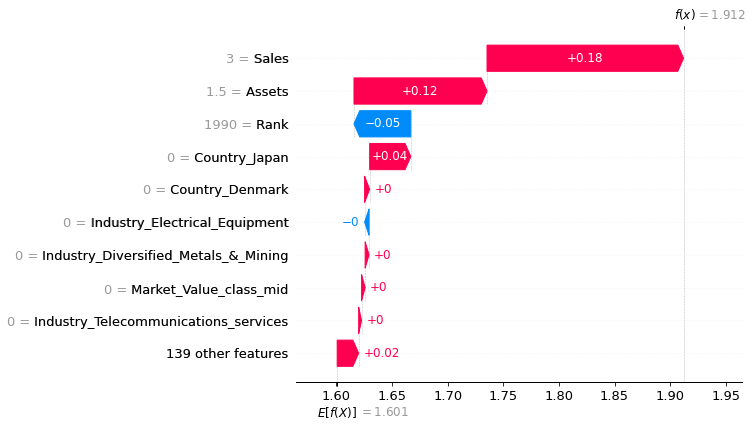

In [19]:
shap.plots.waterfall(shap_values[0])

In [20]:
shap.initjs()
shap.plots.force(shap_values[0])